# 목차
### 1. 셀레니움을 이용한 크롤링
### 2. EDA
- #### EDA(1) 판매 상위인 중고책 10개에 대해 EDA(탐색적 분석)을 수행
- #### EDA(2) 거래등록일과 관련한 시계열 확인을 통해 주기성 등의 인사이트를 파악
- #### EDA(3) 및 머신러닝(의사결정나무)를 활용한 할인율 예측 회귀분석모델 만들기 위한 데이터 전처리

### 예측모델과 분류모델 제작
- #### 3-1. 머신러닝(의사결정나무)를 활용한 할인율 예측 모델 만들기
- #### 3-2.할인율 구간(밴드) 분류하는 Decision Tree Model 만들기






 각 목차별로 내용이 길기에, 궁금한 부분에 맞춰 스킵해가며 보시는 것도 좋을 것 같습니다.

# 1. 셀레니움을 이용한 크롤링

In [109]:
!pip install selenium # 웹크롤링에 필요한 셀레니움을 설치합니다. 이외에도 chromedriver라는 것을 검색해 작업 디렉토리에 욺겨두어야 합니다. 

In [87]:
import pandas as pd

In [2]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time


driver = webdriver.Chrome("./chromedriver")

In [3]:
driver.get("https://bookstore.everytime.kr/")
driver.implicitly_wait(0.1)

# 로그인에 대한 코드가 생략되었지만, 개인정보기 때문에 지웠습니다. 양해 바랍니다.

In [93]:
# 크롤링할 각 요소별로 아래와 같이 xpath라는 주소값을 통해 크롤링합니다.

driver.find_element_by_xpath('//*[@id="items"]/a[1]/h2').click()
book_name = driver.find_element_by_xpath('//*[@id="item"]/div[1]/h1').text
author = driver.find_element_by_xpath('//*[@id="item"]/div[1]/dl/dd[1]').text
cost = driver.find_element_by_xpath('//*[@id="item"]/div[1]/p/span[2]').text
discount_price = driver.find_element_by_xpath('//*[@id="item"]/div[1]/p/span[1]').text
publish_date = driver.find_element_by_xpath('//*[@id="item"]/div[1]/dl/dd[3]').text
transaction_date = driver.find_element_by_xpath('//*[@id="item"]/div[2]/time').text
try:
    transaction_status = driver.find_element_by_class_name('soldout').text
except:
    transaction_status = '판매중'
quality = driver.find_elements_by_class_name('checked') # 이를 수행하면 list로 전체 조회되기 때문에 우선 파싱한 후 아래와 같이 할당합니다.
quality_underline = quality[0].text
quality_write = quality[1].text
quality_bookcover = quality[2].text
quality_name_sign = quality[3].text
quality_page_discolor = quality[4].text
quality_page_damage = quality[5].text
parcel = quality[6].text
direct_transaction_available = quality[7].text
transaction_position = driver.find_element_by_xpath('//*[@id="item"]/div[4]/dl/dd[3]').text

driver.back()

In [98]:
# 데이터프레임을 생성하고, 테스트로 크롤링한 결과를 아래와 같이 확인해봅니다. 잘 진행되는 것을 알 수 있습니다.

df = pd.DataFrame(columns=range(16))
df.loc[0] = [book_name,author,cost,discount_price,publish_date, transaction_date, transaction_status
                   ,quality_underline,quality_write,quality_bookcover
                   ,quality_name_sign,quality_page_discolor,quality_page_damage
                   ,parcel, direct_transaction_available, transaction_position]

df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Kotler의 마케팅 원리,"필립 코틀러, 개리 암스트롱","40,000원","32,000원",2021년 8월 30일,2022년 11월 28일,판매중,없음,없음,깨끗하지않음,없음,없음,없음,가능,가능,한양대 서울캠


In [103]:
# 해당 동적 웹페이지는 최근 등록일을 기준으로 최대 4천개의 중고책에 대해서만 조회가 가능합니다. 따라서 다음과 같이 4000개의 중고책 정보를 크롤링하는 반복문을 수행해줍니다.


# print(i) 크롤링 중간 에러 발생시 어디서부터 다시 크롤링할지 확인하기 위함
# start_page_scroll -= 131 크롤링 중간에 에러 발생시 이전단계로 페이지 스크롤링하기 위함

start_page_scroll = 50 # 첫번째 품목이 최상단에 놓이도록 페이지의 스크롤을 설정하기 위한 좌표값입니다.

for i in range(1,4001):
    driver.execute_script("window.scrollTo(%d, %d)" %(start_page_scroll, start_page_scroll))
    driver.find_element_by_xpath('//*[@id="items"]/a[%d]/h2' %i).click()
    
    book_name = driver.find_element_by_xpath('//*[@id="item"]/div[1]/h1').text
    author = driver.find_element_by_xpath('//*[@id="item"]/div[1]/dl/dd[1]').text
    try:
        cost = driver.find_element_by_xpath('//*[@id="item"]/div[1]/p/span[2]').text
    except:
        cost = 'NaN'
    discount_price = driver.find_element_by_xpath('//*[@id="item"]/div[1]/p/span[1]').text
    try:
        publish_date = driver.find_element_by_xpath('//*[@id="item"]/div[1]/dl/dd[3]').text
    except:
        publish_date = 'NaN'
    transaction_date = driver.find_element_by_xpath('//*[@id="item"]/div[2]/time').text
    try:
        transaction_status = driver.find_element_by_class_name('soldout').text
    except:
        transaction_status = '판매중'
    quality = driver.find_elements_by_class_name('checked') # list로 전체 조회되기 때문에 우선 파싱한 후 아래와 같이 할당.
    quality_underline = quality[0].text
    quality_write = quality[1].text
    quality_bookcover = quality[2].text
    quality_name_sign = quality[3].text
    quality_page_discolor = quality[4].text
    quality_page_damage = quality[5].text
    parcel = quality[6].text
    direct_transaction_available = quality[7].text
    try:
        transaction_position = driver.find_element_by_xpath('//*[@id="item"]/div[4]/dl/dd[3]').text
    except:
        transaction_position = '직거래불가'
    
    df.loc[i-1] = [book_name,author,cost,discount_price,publish_date, transaction_date, transaction_status
                   ,quality_underline,quality_write,quality_bookcover
                   ,quality_name_sign,quality_page_discolor,quality_page_damage
                   ,parcel, direct_transaction_available, transaction_position]
    
    driver.back()
    start_page_scroll += 131

In [106]:
# 안전을 위해 다음과 같이 csv 파일을 저장해주었습니다.

# df.to_csv('used_book_info.csv', index = False)
# df.to_csv('used_book_info_insurance.csv', index = False)

In [3]:
df = pd.read_csv('used_book_info_insurance.csv')
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Kotler의 마케팅 원리,"필립 코틀러, 개리 암스트롱","40,000원","32,000원",2021년 8월 30일,2022년 11월 28일,판매중,없음,없음,깨끗하지않음,없음,없음,없음,가능,가능,한양대 서울캠
1,원가회계,백태영,"30,000원","25,000원",2021년 1월 15일,2022년 11월 28일,판매중,없음,없음,깨끗하지않음,없음,없음,없음,가능,가능,한양대 서울캠
2,회계원리(사례와 함께하는)(3판)(양장본 Hardcover),"최종학, 송혁준","35,000원","28,000원",2020년 2월 5일,2022년 11월 28일,판매중,없음,없음,깨끗하지않음,있음,있음,있음,가능,가능,한양대 서울캠
3,Intermediate Accounting(IFRS Edition),Kieso,"59,000원","40,000원",2018년 2월 1일,2022년 11월 28일,판매중,없음,없음,깨끗하지않음,있음,있음,있음,가능,가능,한양대 서울캠
4,해커스 보카(Hackers Vocabulary)(개정판 2판),David Cho,"16,900원","10,000원",2021년 12월 13일,2022년 11월 23일,판매중,없음,없음,깨끗함,없음,없음,없음,가능,가능,한양대 서울캠
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,Professional Academic English,한양대학교 대학영어교육위원회,"19,000원","7,000원",2016년 8월 10일,2021년 8월 17일,이 책은 판매가 완료되었습니다.,연필/샤프,연필/샤프,볼펜/형광펜,깨끗함,없음,없음,없음,가능,한양대 서울캠
3996,Professional Academic English,한양대학교 대학영어교육위원회,"19,000원","9,000원",2016년 8월 10일,2021년 8월 17일,판매중,없음,없음,깨끗하지않음,있음,없음,없음,가능,가능,한양대 서울캠
3997,필수생물학(핵심)(2판)(핵심)(2판),Marielle Hoefnagel,"28,000원","18,000원",2019년 3월 25일,2021년 8월 17일,이 책은 판매가 완료되었습니다.,볼펜/형광펜,연필/샤프,깨끗함,있음,있음,있음,가능,가능,한양대 서울캠
3998,현대 중국의 이해,박대훈,"15,000원","7,000원",2016년 2월 25일,2021년 8월 16일,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,가능,불가,직거래불가


In [9]:
# 데이터프레임의 이름을 이해할 수 있도록 변경해줍니다.
df.columns = ['책제목', '저자', '원가', '중고가', '출판일', '거래등록일', '판매여부', '밑줄흔적','필기흔적','겉표지','이름기입','페이지변색','페이지훼손','택배','직거래','원하는장소']

In [10]:
# 데이터프레임의 컬럼별로 정제(cleansing)하기 위한 작업을 수행합니다.
import re

In [111]:
# cleasing 함수 

def cleasing(text):
    repl =''
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)' # 자음, 모음 제거
    text = re.sub(pattern= pattern, repl=repl, string=text)
    pattern = '[^\w\s]' # 특수기호 제거
    text = re.sub(pattern= pattern, repl=repl, string=text)    
    pattern = '[가-히\s]' # 특수기호 제거
    text = re.sub(pattern= pattern, repl=repl, string=text)
    return text

def datetime_changer(yyyymmdd):
    y, m, d = yyyymmdd.split('-')
    m = '0'+m
    d = '0'+d
    
    return y + '-' + m[-2:] + '-' + d[-2:]

In [15]:
df['원가'] = df['원가'].map(lambda x: cleasing(str(x)))
df['중고가'] = df['중고가'].map(lambda x: cleasing(str(x)))

df['출판일'] = df['출판일'].str.replace('년 ','-')
df['출판일'] = df['출판일'].str.replace('월 ','-')
df['출판일'] = df['출판일'].str.replace('일','')
df['출판일'].apply(datetime_changer)
df['출판일'] = pd.to_datetime(df['출판일'])

df['거래등록일'] = df['거래등록일'].str.replace('년 ','-')
df['거래등록일'] = df['거래등록일'].str.replace('월 ','-')
df['거래등록일'] = df['거래등록일'].str.replace('일','')
df['거래등록일'].apply(datetime_changer)
df['거래등록일'] = pd.to_datetime(df['거래등록일'])

In [16]:
df

,책제목,저자,원가,중고가,출판일,거래등록일,판매여부,밑줄흔적,필기흔적,겉표지,이름기입,페이지변색,페이지훼손,택배,직거래,원하는장소
0,Kotler의 마케팅 원리,"필립 코틀러, 개리 암스트롱",40000,32000,2021-08-30,2022-11-28,판매중,없음,없음,깨끗하지않음,없음,없음,없음,가능,가능,한양대 서울캠
1,원가회계,백태영,30000,25000,2021-01-15,2022-11-28,판매중,없음,없음,깨끗하지않음,없음,없음,없음,가능,가능,한양대 서울캠
2,회계원리(사례와 함께하는)(3판)(양장본 Hardcover),"최종학, 송혁준",35000,28000,2020-02-05,2022-11-28,판매중,없음,없음,깨끗하지않음,있음,있음,있음,가능,가능,한양대 서울캠
3,Intermediate Accounting(IFRS Edition),Kieso,59000,40000,2018-02-01,2022-11-28,판매중,없음,없음,깨끗하지않음,있음,있음,있음,가능,가능,한양대 서울캠
4,해커스 보카(Hackers Vocabulary)(개정판 2판),David Cho,16900,10000,2021-12-13,2022-11-23,판매중,없음,없음,깨끗함,없음,없음,없음,가능,가능,한양대 서울캠
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,Professional Academic English,한양대학교 대학영어교육위원회,19000,7000,2016-08-10,2021-08-17,이 책은 판매가 완료되었습니다.,연필/샤프,연필/샤프,볼펜/형광펜,깨끗함,없음,없음,없음,가능,한양대 서울캠
3996,Professional Academic English,한양대학교 대학영어교육위원회,19000,9000,2016-08-10,2021-08-17,판매중,없음,없음,깨끗하지않음,있음,없음,없음,가능,가능,한양대 서울캠
3997,필수생물학(핵심)(2판)(핵심)(2판),Marielle Hoefnagel,28000,18000,2019-03-25,2021-08-17,이 책은 판매가 완료되었습니다.,볼펜/형광펜,연필/샤프,깨끗함,있음,있음,있음,가능,가능,한양대 서울캠
3998,현대 중국의 이해,박대훈,15000,7000,2016-02-25,2021-08-16,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,가능,불가,직거래불가


In [157]:
# df.to_csv('check.csv')

In [8]:
df = pd.read_csv('check.csv', encoding='cp949')
df.drop(columns=['Unnamed: 0'],axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   책제목     4000 non-null   object
 1   저자      4000 non-null   object
 2   원가      4000 non-null   int64 
 3   중고가     4000 non-null   int64 
 4   출판일     4000 non-null   object
 5   거래등록일   4000 non-null   object
 6   판매여부    4000 non-null   object
 7   밑줄흔적    4000 non-null   object
 8   필기흔적    4000 non-null   object
 9   겉표지     4000 non-null   object
 10  이름기입    4000 non-null   object
 11  페이지변색   4000 non-null   object
 12  페이지훼손   4000 non-null   object
 13  택배      4000 non-null   object
 14  직거래     4000 non-null   object
 15  원하는장소   4000 non-null   object
dtypes: int64(2), object(14)
memory usage: 500.1+ KB


# 2. EDA(1) 판매 상위인 중고책 10개에 대해 EDA(탐색적 분석)을 수행하도록 하겠습니다.

In [12]:
# importing packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

plt.rcParams['figure.figsize'] = [30, 10]

In [16]:
frequency = df[df.판매여부 == '이 책은 판매가 완료되었습니다.']['책제목'].value_counts()[:10]

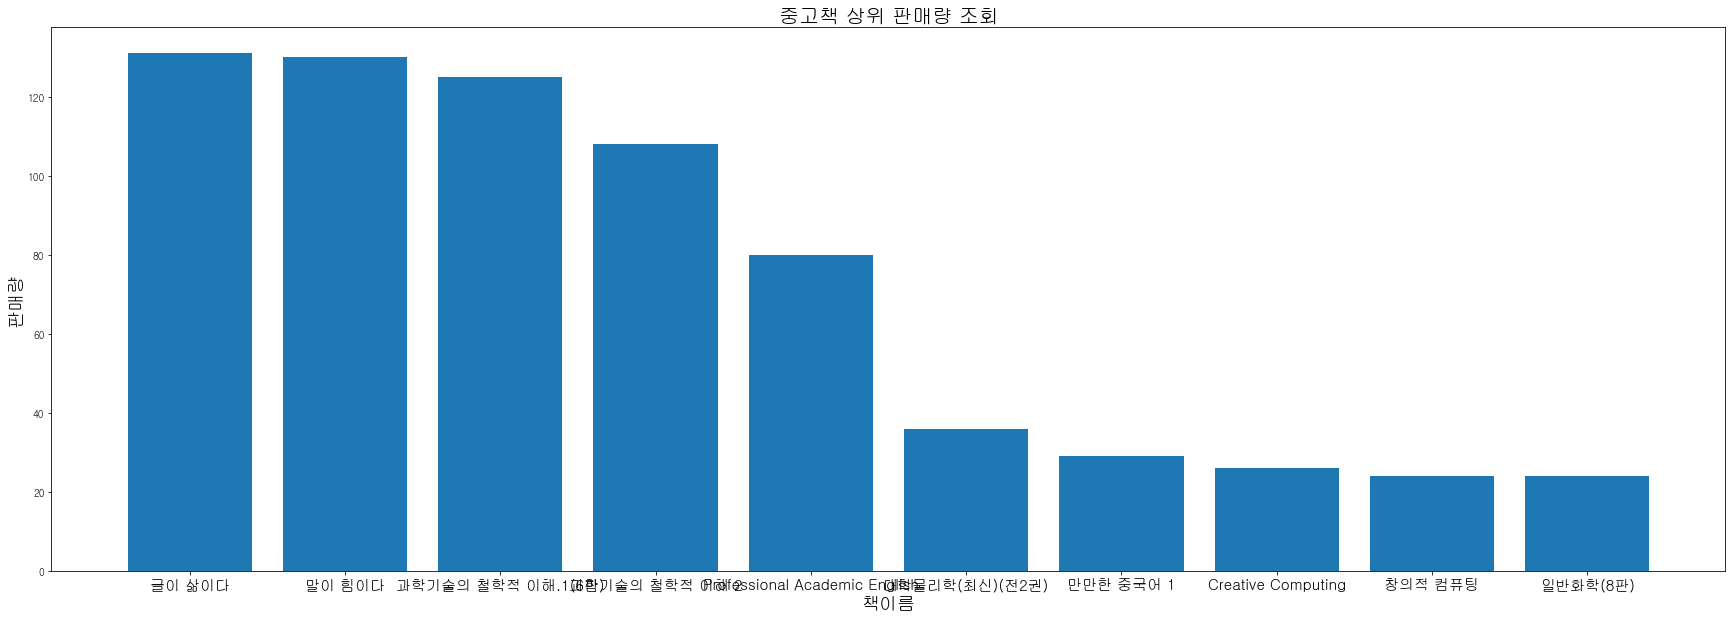

In [14]:
label = list(frequency.index)
index = np.arange(len(label))

plt.bar(index, frequency)
plt.title('중고책 상위 판매량 조회', fontsize=20)

plt.xlabel('책이름', fontsize=18)

plt.ylabel('판매량', fontsize=18)

plt.xticks(index, label, fontsize=15)

plt.show()

    특징이 명확히 구분됩니다.
    1) 먼저 거래되는 상위 5개 중고책은 모든 학생이 들어야하는 필수교양 수업 교과서입니다.
    2) 대학물리학 및 일반화학은 공대생의 전공필수 과목입니다.
    3) 창의적 컴퓨팅은 문과계열 필수교양 교재, Creative Computing은 이과계열 필수교양 교재입니다.

    우선 '글이 삶이다'라는 책을 다시 조회해 오랜 기간동안 누적되어온 거래 데이터를 크롤링하고, 이를 바탕으로 시계열 분석을 통해 언제 구매하면 좋을지, 언제 중고 판매가가 좋게 형성되는지 확인해보겠습니다.

# 2. EDA(2) 거래등록일과 관련한 시계열 확인을 통해 주기성 등의 인사이트를 파악코자 합니다.

In [57]:
# 가장 많은 거래량을 갖는 글이 삶이다라는 책에 대해서 집중적으로 확인해보겠습니다. 최근 등록 4천개의 중고책 정보만 나오는 웹페이지의 특성상 이렇게 별개로 확인하는 것이 놓쳐진 많은 거래를 포착할 수 있습니다.

subject = '글이 삶이다'

elem = driver.find_element_by_xpath('//*[@id="search"]/form/input')
elem.clear()
elem.send_keys(subject)
elem.send_keys(Keys.RETURN)

top1_df = pd.DataFrame(columns=range(16))






start_page_scroll = 50






for i in range(0,1000):
    driver.execute_script("window.scrollTo(%d, %d)" %(start_page_scroll, start_page_scroll))
    try:
        driver.find_element_by_xpath('//*[@id="items"]/a[%d]/h2' %i).click()
    except:
        break
    
    book_name = driver.find_element_by_xpath('//*[@id="item"]/div[1]/h1').text
    author = driver.find_element_by_xpath('//*[@id="item"]/div[1]/dl/dd[1]').text
    try:
        cost = driver.find_element_by_xpath('//*[@id="item"]/div[1]/p/span[2]').text
    except:
        cost = 'NaN'
    discount_price = driver.find_element_by_xpath('//*[@id="item"]/div[1]/p/span[1]').text
    try:
        publish_date = driver.find_element_by_xpath('//*[@id="item"]/div[1]/dl/dd[3]').text
    except:
        publish_date = 'NaN'
    transaction_date = driver.find_element_by_xpath('//*[@id="item"]/div[2]/time').text
    try:
        transaction_status = driver.find_element_by_class_name('soldout').text
    except:
        transaction_status = '판매중'
    quality = driver.find_elements_by_class_name('checked') # list로 전체 조회되기 때문에 우선 파싱한 후 아래와 같이 할당.
    quality_underline = quality[0].text
    quality_write = quality[1].text
    quality_bookcover = quality[2].text
    quality_name_sign = quality[3].text
    quality_page_discolor = quality[4].text
    quality_page_damage = quality[5].text
    parcel = quality[6].text
    direct_transaction_available = quality[7].text
    try:
        transaction_position = driver.find_element_by_xpath('//*[@id="item"]/div[4]/dl/dd[3]').text
    except:
        transaction_position = '직거래불가'
    
    # 값을 저장할 데이터프레임 변경
    top1_df.loc[i-1] = [book_name,author,cost,discount_price,publish_date, transaction_date, transaction_status
                   ,quality_underline,quality_write,quality_bookcover
                   ,quality_name_sign,quality_page_discolor,quality_page_damage
                   ,parcel, direct_transaction_available, transaction_position]
    
    driver.back()
    start_page_scroll += 131

In [63]:
top1_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,글이 삶이다,한양대학교 교양국어교육위원회,"18,000원","7,000원",2017년 2월 20일,2022년 11월 18일,판매중,없음,없음,깨끗함,없음,없음,없음,가능,불가,직거래불가
1,글이 삶이다,한양대학교 교양국어교육위원회,"18,000원","5,000원",2017년 2월 20일,2022년 11월 5일,판매중,없음,없음,깨끗함,없음,없음,없음,가능,가능,한양대 서울캠
2,글이 삶이다,한양대학교 교양국어교육위원회,"18,000원","8,000원",2017년 2월 20일,2022년 11월 5일,판매중,없음,없음,깨끗함,없음,없음,없음,가능,가능,한양대 서울캠
3,글이 삶이다,한양대학교 교양국어교육위원회,"18,000원","6,000원",2017년 2월 20일,2022년 11월 2일,판매중,없음,없음,깨끗함,없음,없음,없음,불가,가능,한양대 서울캠
4,글이 삶이다,한양대학교 교양국어교육위원회,"18,000원","8,000원",2017년 2월 20일,2022년 10월 4일,판매중,없음,없음,깨끗함,없음,없음,없음,가능,불가,직거래불가
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
660,글이 삶이다,한양대학교 교양국어교육위원회,"18,000원","5,000원",2017년 2월 20일,2017년 7월 5일,이 책은 판매가 완료되었습니다.,없음,볼펜/형광펜,깨끗함,있음,없음,없음,불가,가능,한양대 서울캠
661,글이 삶이다,한양대학교 교양국어교육위원회,"18,000원","10,000원",2017년 2월 20일,2017년 7월 4일,이 책은 판매가 완료되었습니다.,없음,연필/샤프,깨끗하지않음,없음,없음,있음,불가,가능,한양대 서울캠
662,글이 삶이다,한양대학교 교양국어교육위원회,"18,000원","13,000원",2017년 2월 20일,2017년 6월 22일,이 책은 판매가 완료되었습니다.,없음,연필/샤프,깨끗하지않음,있음,있음,없음,가능,가능,화곡역 5호선
663,글이 삶이다,한양대학교 교양국어교육위원회,"18,000원","14,000원",2017년 2월 20일,2017년 6월 22일,이 책은 판매가 완료되었습니다.,볼펜/형광펜,볼펜/형광펜,깨끗함,없음,있음,없음,불가,가능,한양대 서울캠


In [77]:
# 데이터프레임의 이름을 이해할 수 있도록 변경해줍니다.
top1_df.columns = ['책제목', '저자', '원가', '중고가', '출판일', '거래등록일', '판매여부', '밑줄흔적','필기흔적','겉표지','이름기입','페이지변색','페이지훼손','택배','직거래','원하는장소']

# 데이터프레임 각 컬럼의 형을 분석에 맞게 변형해줍니다.
top1_df['원가'] = top1_df['원가'].map(lambda x: cleasing(str(x)))
top1_df['중고가'] = top1_df['중고가'].map(lambda x: cleasing(str(x)))

top1_df['출판일'] = top1_df['출판일'].str.replace('년 ','-')
top1_df['출판일'] = top1_df['출판일'].str.replace('월 ','-')
top1_df['출판일'] = top1_df['출판일'].str.replace('일','')
top1_df['출판일'].apply(datetime_changer)
top1_df['출판일'] = pd.to_datetime(top1_df['출판일'])

top1_df['거래등록일'] = top1_df['거래등록일'].str.replace('년 ','-')
top1_df['거래등록일'] = top1_df['거래등록일'].str.replace('월 ','-')
top1_df['거래등록일'] = top1_df['거래등록일'].str.replace('일','')
top1_df['거래등록일'].apply(datetime_changer)
top1_df['거래등록일'] = pd.to_datetime(top1_df['거래등록일'])

top1_df['원가'] = top1_df['원가'].map(int)
top1_df['중고가'] = top1_df['중고가'].map(int)

In [78]:
top1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 665 entries, 0 to 664
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   책제목     665 non-null    object        
 1   저자      665 non-null    object        
 2   원가      665 non-null    int64         
 3   중고가     665 non-null    int64         
 4   출판일     665 non-null    datetime64[ns]
 5   거래등록일   665 non-null    datetime64[ns]
 6   판매여부    665 non-null    object        
 7   밑줄흔적    665 non-null    object        
 8   필기흔적    665 non-null    object        
 9   겉표지     665 non-null    object        
 10  이름기입    665 non-null    object        
 11  페이지변색   665 non-null    object        
 12  페이지훼손   665 non-null    object        
 13  택배      665 non-null    object        
 14  직거래     665 non-null    object        
 15  원하는장소   665 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(12)
memory usage: 88.3+ KB


In [3]:
# 데이터프레임 중간저장
# top1_df.to_csv('top_transaction_book_data.csv', index=False)
top1_df = pd.read_csv('top_transaction_book_data.csv')

In [6]:
# 판매된 데이터만 보겠습니다.
top1_df = top1_df[top1_df['판매여부'] == '이 책은 판매가 완료되었습니다.']

top1_df.set_index('거래등록일', drop=True, inplace=True)
top1_df

,책제목,저자,원가,중고가,출판일,판매여부,밑줄흔적,필기흔적,겉표지,이름기입,페이지변색,페이지훼손,택배,직거래,원하는장소
거래등록일,,,,,,,,,,,,,,,
2022-09-15,글이 삶이다,한양대학교 교양국어교육위원회,18000,5000,2017-02-20,이 책은 판매가 완료되었습니다.,연필/샤프,없음,깨끗함,없음,없음,없음,불가,가능,한양대 서울캠
2022-09-14,글이 삶이다,한양대학교 교양국어교육위원회,18000,6000,2017-02-20,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,가능,가능,한양대 서울캠
2022-09-13,글이 삶이다,한양대학교 교양국어교육위원회,18000,5000,2017-02-20,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,불가,가능,한양대 서울캠
2022-09-12,글이 삶이다,한양대학교 교양국어교육위원회,18000,5000,2017-02-20,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,불가,가능,한양대 서울캠
2022-09-11,글이 삶이다,한양대학교 교양국어교육위원회,18000,5000,2017-02-20,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,가능,가능,한양대 서울캠
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-05,글이 삶이다,한양대학교 교양국어교육위원회,18000,5000,2017-02-20,이 책은 판매가 완료되었습니다.,없음,볼펜/형광펜,깨끗함,있음,없음,없음,불가,가능,한양대 서울캠
2017-07-04,글이 삶이다,한양대학교 교양국어교육위원회,18000,10000,2017-02-20,이 책은 판매가 완료되었습니다.,없음,연필/샤프,깨끗하지않음,없음,없음,있음,불가,가능,한양대 서울캠
2017-06-22,글이 삶이다,한양대학교 교양국어교육위원회,18000,13000,2017-02-20,이 책은 판매가 완료되었습니다.,없음,연필/샤프,깨끗하지않음,있음,있음,없음,가능,가능,화곡역 5호선


In [7]:
# 주별로, 월별로 거래를 시각화해보고자 아래와 같이 resample 메서드를 활용했습니다.
top1_df_per_week = top1_df.resample('W')['책제목'].size()
top1_df_per_month = top1_df.resample('M')['책제목'].size()

<AxesSubplot:xlabel='거래등록일'>

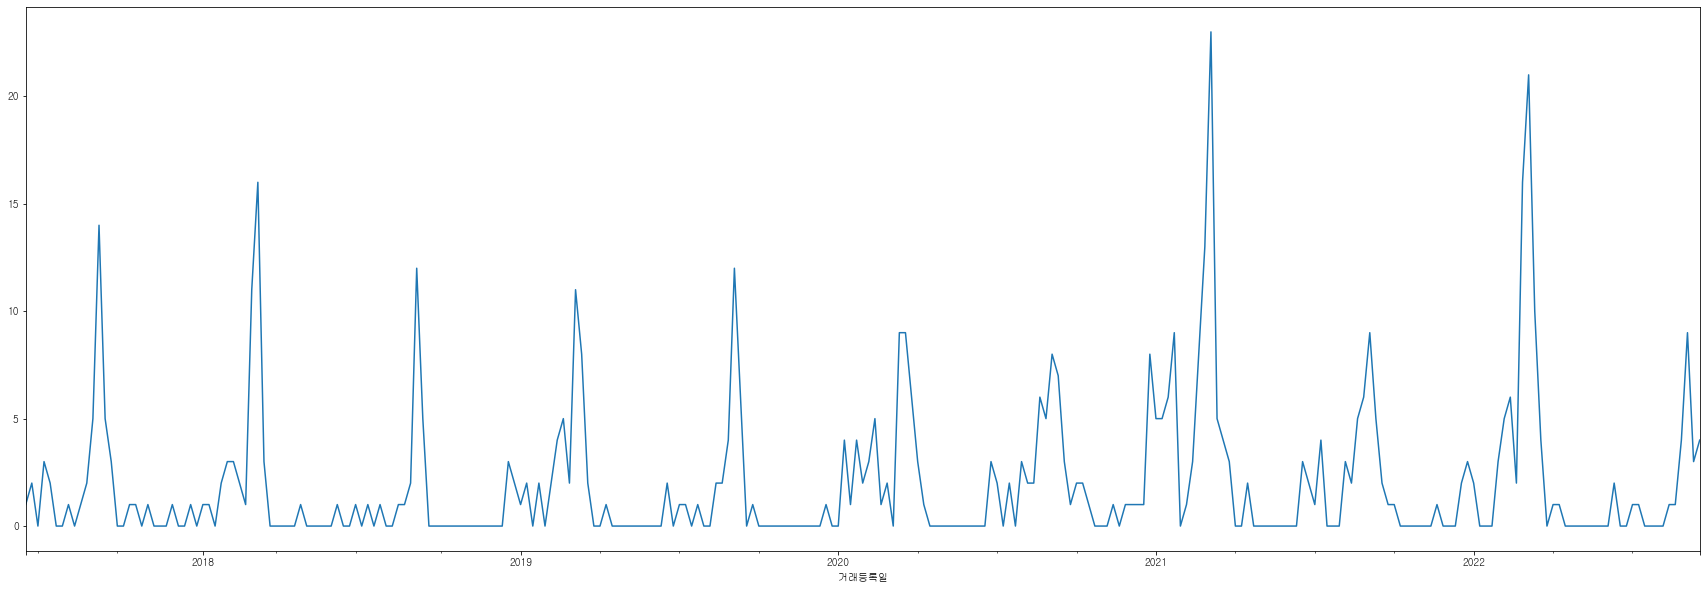

In [13]:
# 주간 거래량으로도 주기성이 분명하게 보입니다.
top1_df_per_week.plot()

<AxesSubplot:xlabel='거래등록일'>

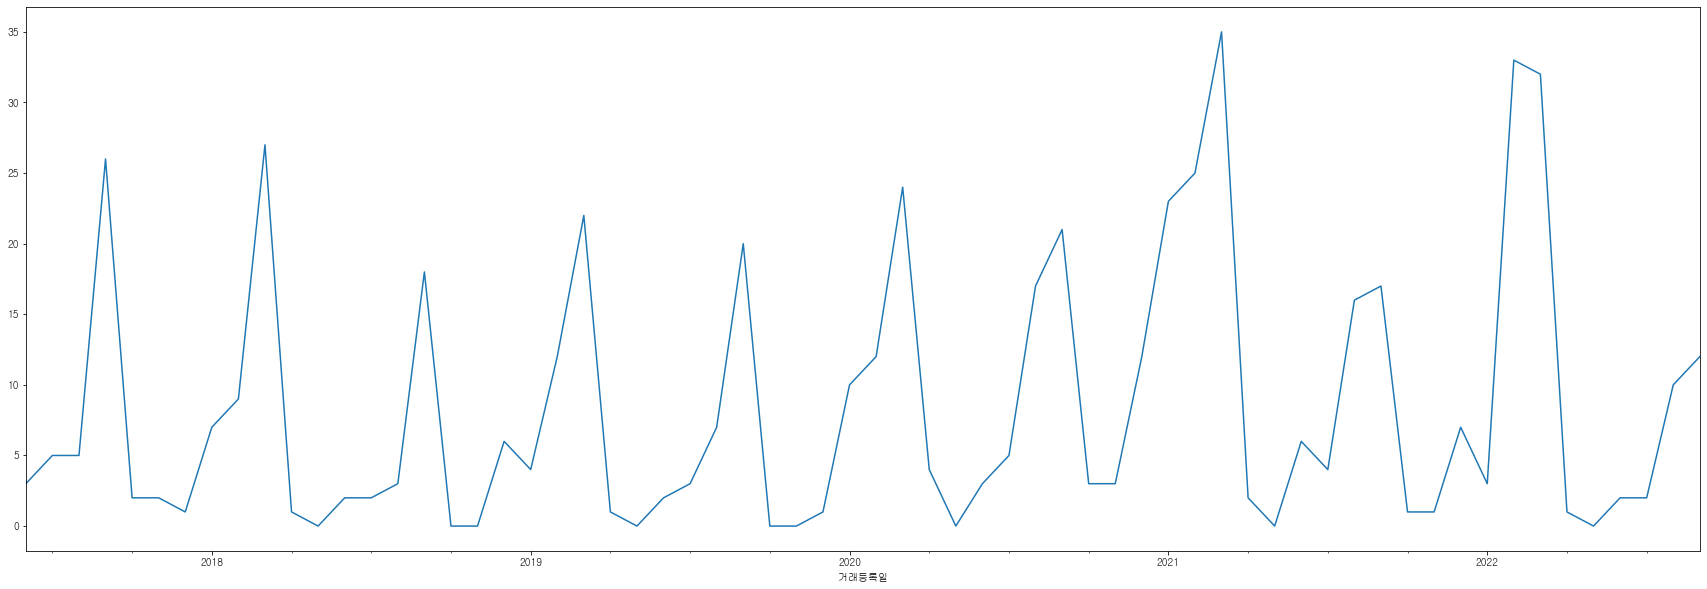

In [14]:
# 보다 강건한 결과를 보기위해 월별로 다시 시각화한 결과, 개강시즌인 3월과 9월에 거래가 활발해짐을 볼 수 있습니다.
top1_df_per_month.plot()

    그래프로 확인해본 결과, 매해 3월과 9월 초에 높은 거래량, 그리고 나머지 기간에는 거래가 급격히 감소하거나 아예 없는 것을 볼 수 있습니다. 개강 시기를 맞춰서 교재가 급하게 필요해져 구매하는 특성에 기인하는 것으로 볼 수 있습니다.

    또 하나 볼 요소가 있습니다. 거래가격 폭인데요, 판매자는 보다 좋은 가격에 판매하고싶은 욕구가 있기 때문에 앞서 얻은 개월별 판매량 인사이트를 이어서 어느 개월에 판매하면 가장 높은 가격에 판매할 가능성이 있는지 바이올린플롯(violinplot)이라는 그래프 시각화 방법을 활용해보겠습니다.

In [101]:
import seaborn as sns

In [15]:
tmp_top1_df = top1_df
tmp_top1_df['month'] = top1_df.index.month

<AxesSubplot:xlabel='month', ylabel='중고가'>

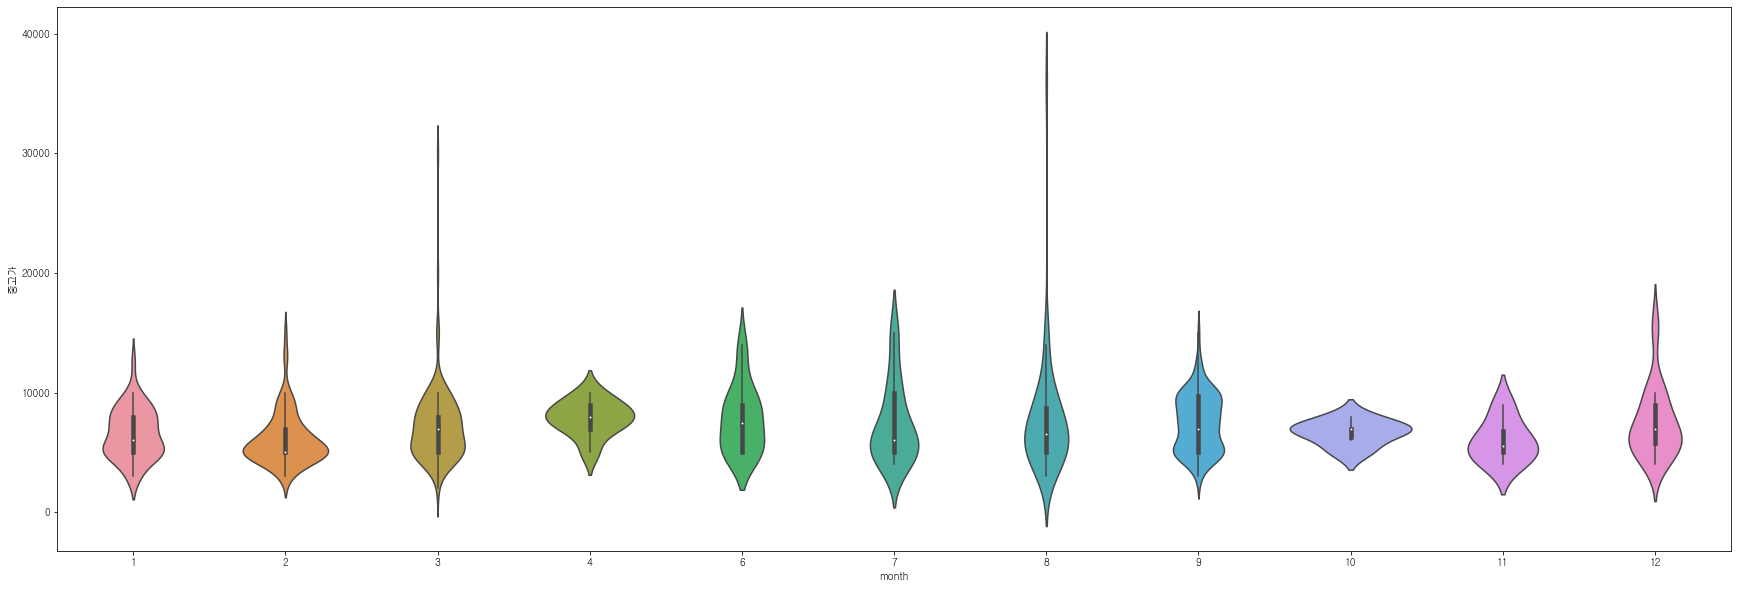

In [16]:
sns.violinplot(x='month',y='중고가', data=tmp_top1_df)

    개강 시기(3월, 8월)에 가격이 높게 치솟은 거래들이 있음을 볼 수 있습니다. 새 교과서등을 구매하고자 하는 수요때문일 것으로 추측됩니다.

    지금까지의 탐색적 분석을 통해, 크게 두가지 인사이트를 얻을 수 있었습니다.

- 개강시기(3월, 8월)에 거래가 활발해 용이하게 판매할 수 있다.
- 마찬가지로 개강시기에 높은 가격으로 보다 큰 이익을 얻을 수 있는 기회가 존재한다.



        또한 2가지 판매 전략을 세울 수 있습니다.

- 평균적 거래가격이 가장 높은 거래 시즌을 파악해, 평균적으로 높은 가격에 거래가능한 시즌에 매물을 판매한다.
- 월별 평균 거래량 또한 중요. 거래가 활발한 시즌을 파악해 안정적으로 판매가 가능하도록 한다.
- 추가로, 활발한 거래시즌 데이터만 취합해, 이들의 품질 변수(밑줄흔적, 페이지흔적)를 활용해 품질별 거래가격을 예측해 적정가에 판매를 용이하게 한다.

- 한양대에서 편찬한 상위거래 도서는 필수 교과목 -> 품질에 상관없이 거래가가 형성.
- 출판일과 판매일(대체변수 판매등록일)의 차이가 클수록 중고가격이 하락할 것.


# 2. EDA(3) + 머신러닝(의사결정나무)를 활용한 할인율 예측 회귀분석모델 만들기 위한 데이터 전처리 수행
    출판일로부터 거래등록일까지의 기간차, 거래등록월, 밑줄흔적~페이지훼손 여부에 대한 조건을 바탕으로 중고가가 원가대비 얼마나 할인되는지를 예측하고자 합니다.
    우선 상위 10개 거래품목에 대해서 재검색하고 각각 웹크롤링해 정보를 더 얻을 수 있도록 아래와 같이 크롤링을 수행해줍니다.

In [17]:
list(freq.index)

['말이 힘이다',
 '글이 삶이다',
 '과학기술의 철학적 이해.1(6판)',
 '과학기술의 철학적 이해 2',
 'Professional Academic English',
 'Creative Computing',
 '대학물리학(최신)(전2권)',
 'Calculus: Early Transcendentals',
 '창의적 컴퓨팅',
 '현대 중국의 이해',
 '일반화학(8판)',
 '만만한 중국어 1',
 '필수생물학(핵심)(2판)(핵심)(2판)',
 '한국 근현대사를 읽는다',
 '거시경제학(9판)(양장본 HardCover)',
 '한국인의 법과 생활(개정판)',
 '저작권법(2판)(양장본 HardCover)',
 '생물학 신 완전정복',
 'Present Yourself 1: Experiences(SB)',
 '맨큐의 경제학',
 'Principles of Marketing, Global Edition',
 '회계원리(사례와 함께하는)(3판)(양장본 Hardcover)',
 '현대재무관리',
 '재무제표분석과 가치평가(K-IFRS)(5판)(양장본 HardCover)',
 '일본어 한대: 초급부터 한대',
 'IFRS 회계원리(3판)(양장본 HardCover)',
 '원가회계',
 '한국인의 법과 생활',
 '미시경제학',
 '핵심일반화학(8판)',
 '교양 스페인어 (개정판)(MP3CD1장포함)',
 '재무제표분석과 가치평가(K-IFRS)(6판)(양장본 HardCover)',
 '특허의 이해(4판)',
 'Intermediate Accounting(IFRS Edition)',
 '성의 과학(웰치)',
 '공업수학(상): 상미분방정식 선형대수 벡터미적분(개정판 10판)',
 'IFRS 중급회계(수정증보판 8판)',
 '공업수학(하)(Kreyszig)(개정판 10판)',
 '경제경영수학(예제로 접근하는)(3판)',
 'IFRS 중급회계(9판)',
 '조직행동론(6판)',
 'IFRS 회계원리(4판)(양장본 HardCover)',
 '미시경제학(3판)(양장본 

In [19]:
top_10_df = pd.DataFrame(columns=range(16))

In [24]:
tmp = 0
start_page_scroll = 50

for subject in list(freq.index)[0:10]:
    elem = driver.find_element_by_xpath('//*[@id="search"]/form/input')
    elem.clear()
    elem.send_keys(subject)
    elem.send_keys(Keys.RETURN)
    start_page_scroll = 50    
    
    for i in range(1,1000):
        driver.execute_script("window.scrollTo(%d, %d)" %(start_page_scroll, start_page_scroll))
        try:
            driver.find_element_by_xpath('//*[@id="items"]/a[%d]/h2' %i).click()
        except:
            break
        
        book_name = driver.find_element_by_xpath('//*[@id="item"]/div[1]/h1').text
        author = driver.find_element_by_xpath('//*[@id="item"]/div[1]/dl/dd[1]').text
        try:
            cost = driver.find_element_by_xpath('//*[@id="item"]/div[1]/p/span[2]').text
        except:
            cost = 'NaN'
        discount_price = driver.find_element_by_xpath('//*[@id="item"]/div[1]/p/span[1]').text
        try:
            publish_date = driver.find_element_by_xpath('//*[@id="item"]/div[1]/dl/dd[3]').text
        except:
            publish_date = 'NaN'
        transaction_date = driver.find_element_by_xpath('//*[@id="item"]/div[2]/time').text
        try:
            transaction_status = driver.find_element_by_class_name('soldout').text
        except:
            transaction_status = '판매중'
        quality = driver.find_elements_by_class_name('checked') # list로 전체 조회되기 때문에 우선 파싱한 후 아래와 같이 할당.
        quality_underline = quality[0].text
        quality_write = quality[1].text
        quality_bookcover = quality[2].text
        quality_name_sign = quality[3].text
        quality_page_discolor = quality[4].text
        quality_page_damage = quality[5].text
        parcel = quality[6].text
        direct_transaction_available = quality[7].text
        try:
            transaction_position = driver.find_element_by_xpath('//*[@id="item"]/div[4]/dl/dd[3]').text
        except:
            transaction_position = '직거래불가'
        
        # 값을 저장할 데이터프레임 변경
        top_10_df.loc[tmp] = [book_name,author,cost,discount_price,publish_date, transaction_date, transaction_status
                    ,quality_underline,quality_write,quality_bookcover
                    ,quality_name_sign,quality_page_discolor,quality_page_damage
                    ,parcel, direct_transaction_available, transaction_position]
        
        tmp += 1
        driver.back()
        start_page_scroll += 131    
    
    
    driver.back()

top_10_df.columns = ['책제목', '저자', '원가', '중고가', '출판일', '거래등록일', '판매여부', '밑줄흔적','필기흔적','겉표지','이름기입','페이지변색','페이지훼손','택배','직거래','원하는장소']


# cleasing 함수 
def cleasing(text):
    repl =''
    pattern = '([ㄱ-ㅎㅏ-ㅣ]+)' # 자음, 모음 제거
    text = re.sub(pattern= pattern, repl=repl, string=text)
    pattern = '[^\w\s]' # 특수기호 제거
    text = re.sub(pattern= pattern, repl=repl, string=text)    
    pattern = '[가-히\s]' # 특수기호 제거
    text = re.sub(pattern= pattern, repl=repl, string=text)
    return text

top_10_df['원가'] = top_10_df['원가'].map(lambda x: cleasing(str(x)))
top_10_df['중고가'] = top_10_df['중고가'].map(lambda x: cleasing(str(x)))

top_10_df['출판일'] = top_10_df['출판일'].str.replace('년 ','-')
top_10_df['출판일'] = top_10_df['출판일'].str.replace('월 ','-')
top_10_df['출판일'] = top_10_df['출판일'].str.replace('일','')
top_10_df['출판일'] = pd.to_datetime(top_10_df['출판일'])

top_10_df['거래등록일'] = top_10_df['거래등록일'].str.replace('년 ','-')
top_10_df['거래등록일'] = top_10_df['거래등록일'].str.replace('월 ','-')
top_10_df['거래등록일'] = top_10_df['거래등록일'].str.replace('일','')
top_10_df['거래등록일'] = pd.to_datetime(top_10_df['거래등록일'])

In [15]:
# top_10_df.to_csv('top10transaction.csv',index=False)
top_10_df = pd.read_csv('top10transaction.csv')

In [16]:
# 판매된 데이터만 보겠습니다.
top_10_df = top_10_df[top_10_df['판매여부'] == '이 책은 판매가 완료되었습니다.']

# 목적변수와 설명변수로 활용할 파생변수를 다음과 같이 만들어줍니다.
top_10_df['할인율'] = (1-top_10_df['중고가'].map(int)/top_10_df['원가'].map(int))
top_10_df['출시이후개월수'] = top_10_df['거래등록일'].dt.to_period('M').astype(int) - top_10_df['출판일'].dt.to_period('M').astype(int)
top_10_df

C:\Users\KANGBY~1\AppData\Local\Temp/ipykernel_5944/1323028281.py:5: FutureWarning: casting period[M] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  top_10_df['출시이후개월수'] = top_10_df['거래등록일'].dt.to_period('M').astype(int) - top_10_df['출판일'].dt.to_period('M').astype(int)


,책제목,저자,원가,중고가,출판일,거래등록일,판매여부,밑줄흔적,필기흔적,겉표지,이름기입,페이지변색,페이지훼손,택배,직거래,원하는장소,할인율,출시이후개월수
5,글이 삶이다,한양대학교 교양국어교육위원회,18000,5000,2017-02-20,2022-09-15,이 책은 판매가 완료되었습니다.,연필/샤프,없음,깨끗함,없음,없음,없음,불가,가능,한양대 서울캠,0.722222,67
6,글이 삶이다,한양대학교 교양국어교육위원회,18000,6000,2017-02-20,2022-09-14,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,가능,가능,한양대 서울캠,0.666667,67
7,글이 삶이다,한양대학교 교양국어교육위원회,18000,5000,2017-02-20,2022-09-13,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,불가,가능,한양대 서울캠,0.722222,67
8,글이 삶이다,한양대학교 교양국어교육위원회,18000,5000,2017-02-20,2022-09-12,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,불가,가능,한양대 서울캠,0.722222,67
9,글이 삶이다,한양대학교 교양국어교육위원회,18000,5000,2017-02-20,2022-09-11,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,가능,가능,한양대 서울캠,0.722222,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,현대 중국의 이해,박대훈,15000,7000,2016-02-25,2021-03-07,이 책은 판매가 완료되었습니다.,없음,볼펜/형광펜,깨끗함,있음,있음,있음,가능,불가,직거래불가,0.533333,61
1276,현대 중국의 이해,박대훈,15000,9000,2016-02-25,2021-03-02,이 책은 판매가 완료되었습니다.,연필/샤프,볼펜/형광펜,없음,깨끗함,없음,없음,없음,가능,직거래불가,0.400000,61
1277,현대 중국의 이해,박대훈,15000,8000,2016-02-25,2021-03-02,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,가능,가능,한양대 서울캠,0.466667,61
1278,현대 중국의 이해,박대훈,15000,10000,2016-02-25,2021-02-26,이 책은 판매가 완료되었습니다.,없음,없음,깨끗함,없음,없음,없음,불가,가능,부평구청역 7호선,0.333333,60


<AxesSubplot:xlabel='출시이후개월수'>

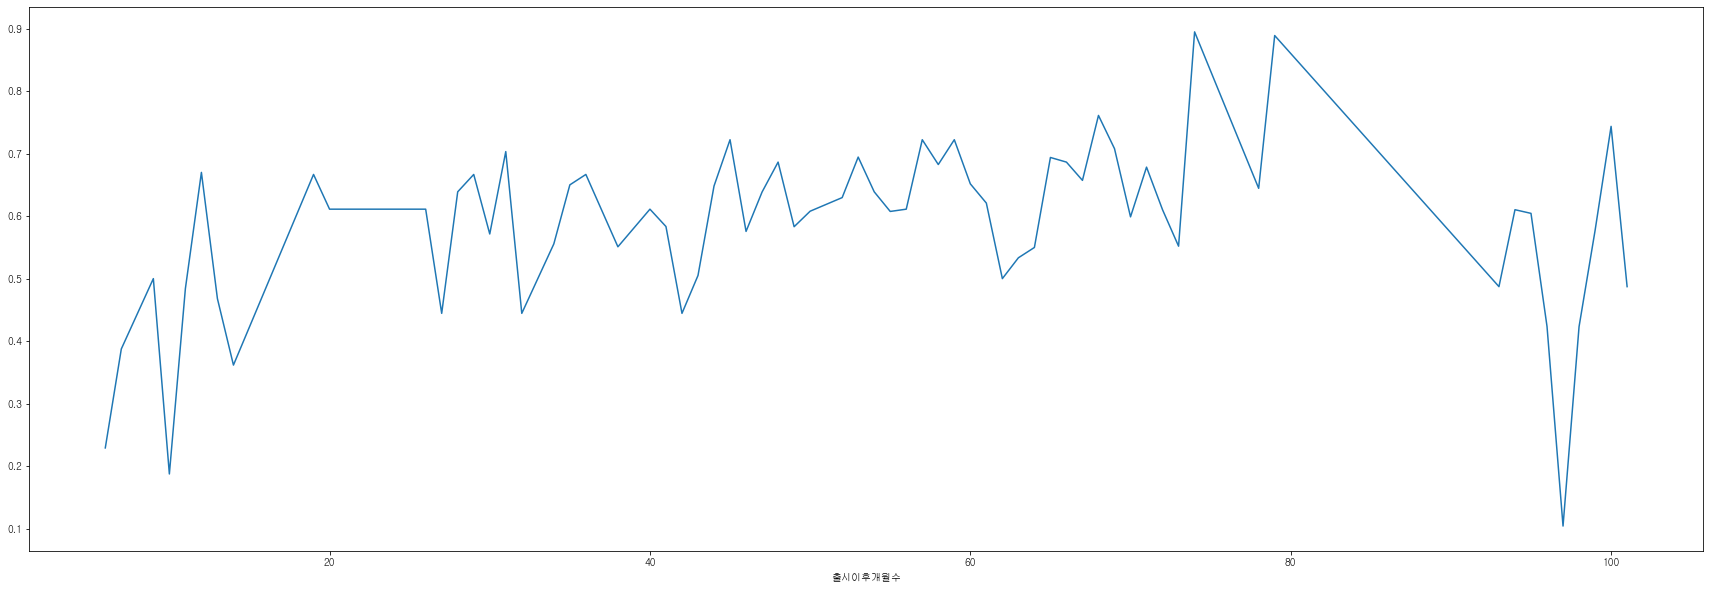

In [17]:
top_10_df.groupby(top_10_df['출시이후개월수'])['할인율'].mean().plot()

C:\Users\KANGBY~1\AppData\Local\Temp/ipykernel_5944/1959186945.py:1: FutureWarning: casting period[A-DEC] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  top_10_df['출시이후연수'] = top_10_df['거래등록일'].dt.to_period('Y').astype(int) - top_10_df['출판일'].dt.to_period('Y').astype(int)


<AxesSubplot:xlabel='출시이후연수'>

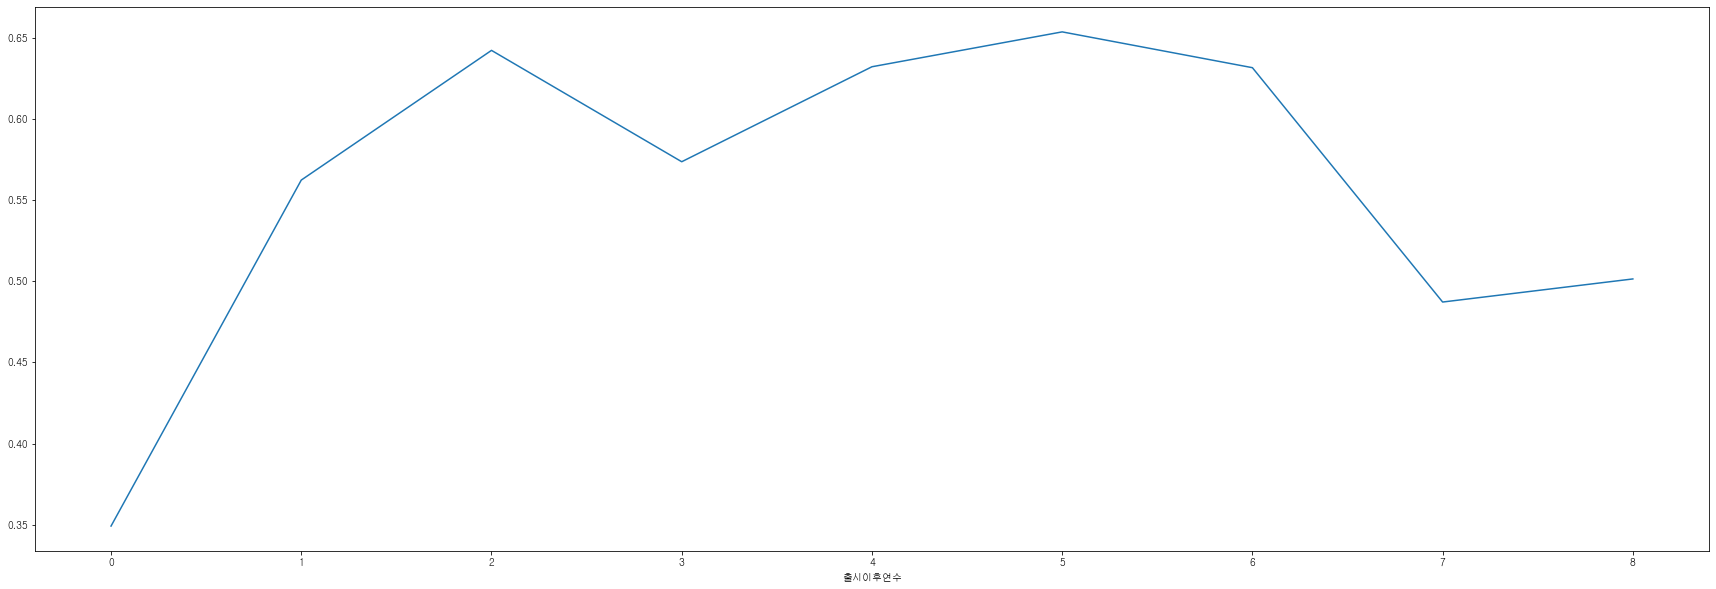

In [18]:
top_10_df['출시이후연수'] = top_10_df['거래등록일'].dt.to_period('Y').astype(int) - top_10_df['출판일'].dt.to_period('Y').astype(int)
top_10_df.groupby(top_10_df['출시이후연수'])['할인율'].mean().plot()

<AxesSubplot:xlabel='출시이후누적분기수'>

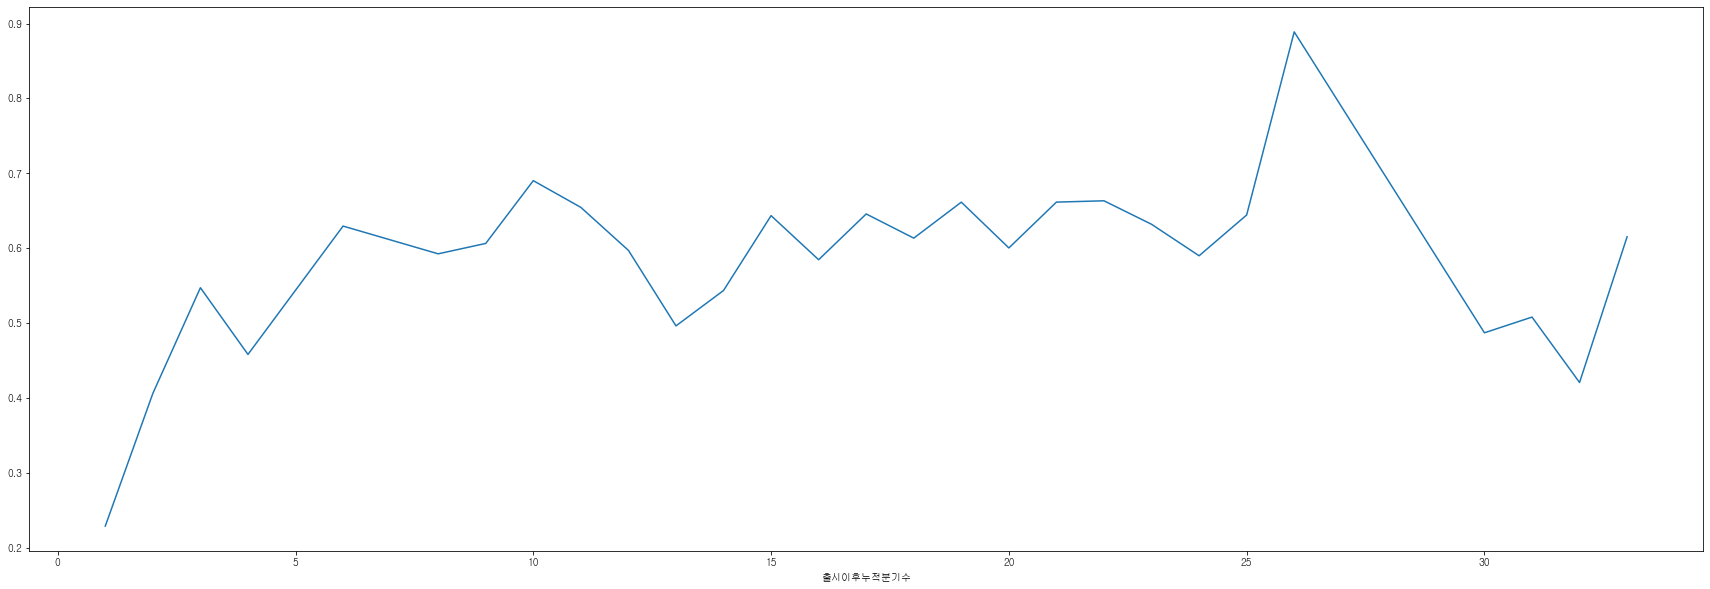

In [19]:
def quarter_month_diff(month_diff):
    # 출시일로부터 3개월씩으로 나눠, 결과적으로 출시 이후 분기별 가격 할인율 동향을 보고자 합니다.
    quarter = (month_diff-1) // 3
    if quarter < 1:
        return 0
    else:
        return quarter

top_10_df['출시이후누적분기수'] = top_10_df['출시이후개월수'].apply(quarter_month_diff)
top_10_df.groupby(top_10_df['출시이후누적분기수'])['할인율'].mean().plot()

<AxesSubplot:xlabel='출시이후누적분기수'>

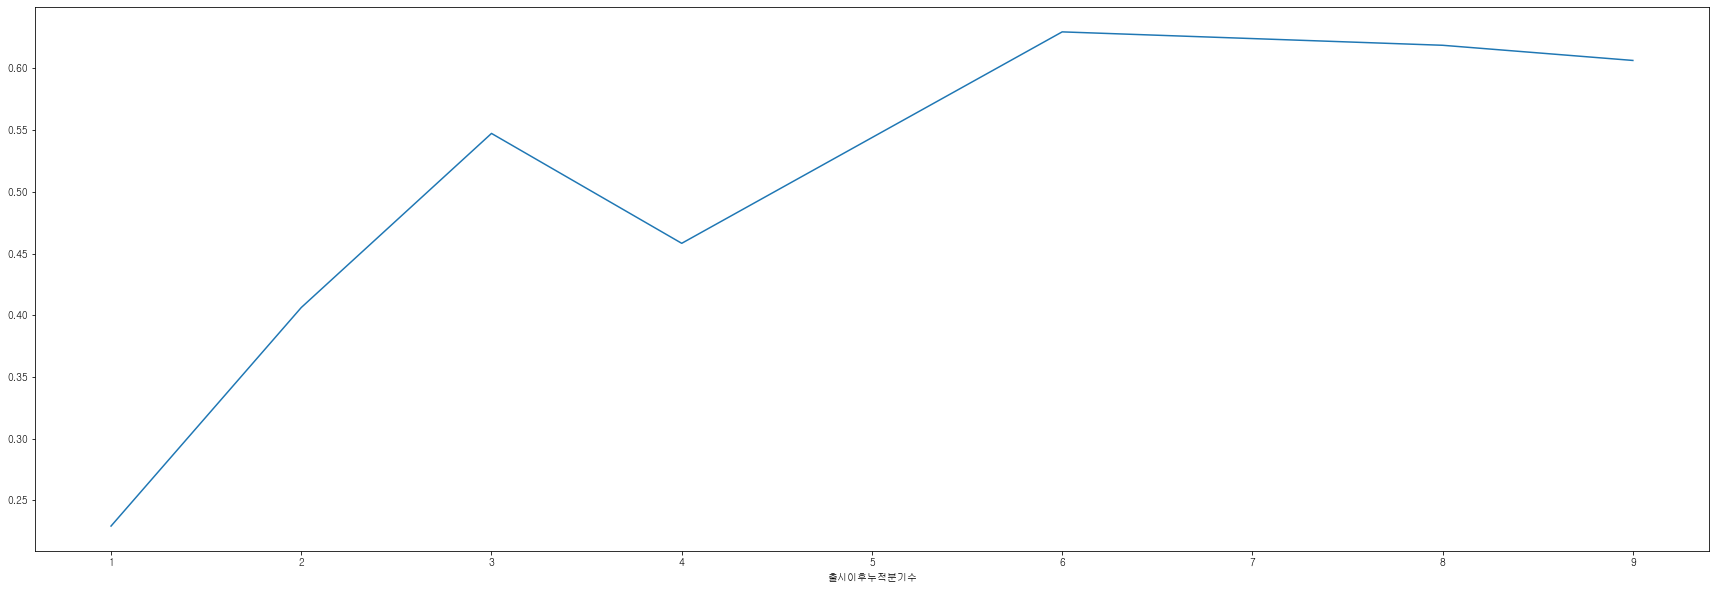

In [22]:
def quarter_month_diff(month_diff):
    # 출시일로부터 3개월씩으로 나눠, 결과적으로 출시 이후 분기별 가격 할인율 동향을 보고자 합니다.
    quarter = (month_diff-1) // 3
    if quarter < 1:
        return 0
    elif quarter > 9:
        return 8
    else:
        return quarter

top_10_df['출시이후누적분기수'] = top_10_df['출시이후개월수'].apply(quarter_month_diff)
top_10_df.groupby(top_10_df['출시이후누적분기수'])['할인율'].mean().plot()

# 3-1. 머신러닝(linear regression, 의사결정나무)를 활용한 할인율 예측 모델 만들기

In [23]:
# 우선 책 상태와 관련한 변수를 명목형 더미변수로 치환해줍니다.
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


le = LabelEncoder()
ohe = OneHotEncoder()


final_df = pd.concat([top_10_df[['출시이후누적분기수']], pd.get_dummies(top_10_df[['필기흔적','밑줄흔적','겉표지','이름기입','페이지변색','페이지훼손']]), top_10_df[['할인율']]],axis=1)

final_df

,출시이후누적분기수,필기흔적_볼펜/형광펜,필기흔적_없음,필기흔적_연필/샤프,밑줄흔적_볼펜/형광펜,밑줄흔적_없음,밑줄흔적_연필/샤프,겉표지_깨끗하지않음,겉표지_깨끗함,겉표지_볼펜/형광펜,...,이름기입_볼펜/형광펜,이름기입_없음,이름기입_있음,페이지변색_깨끗하지않음,페이지변색_깨끗함,페이지변색_없음,페이지변색_있음,페이지훼손_없음,페이지훼손_있음,할인율
5,8,0,1,0,0,0,1,0,1,0,...,0,1,0,0,0,1,0,1,0,0.722222
6,8,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0.666667
7,8,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0.722222
8,8,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0.722222
9,8,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0.722222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,8,1,0,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,1,0.533333
1276,8,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0.400000
1277,8,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0.466667
1278,8,0,1,0,0,1,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0.333333


In [24]:
X = final_df.drop(columns=['할인율'])
y = final_df['할인율']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

print('학습용 데이터 개수: %d' %(len(X_train)))
print('평가용 데이터 개수: %d' %(len(X_test)))

학습용 데이터 개수: 745
평가용 데이터 개수: 187


In [25]:
# 1. 모델을 초기화 합니다.
lrmodel = LinearRegression()
dtmodel = DecisionTreeRegressor()

# 2. train_X, train_Y 데이터를 학습합니다.
lrmodel.fit(X_train, y_train)

# 3. train set에 대한 예측값을 저장합니다.
pred_train = lrmodel.predict(X_train)

In [26]:
# 엘리스 AISW에서 학습한 코드를 활용하였습니다.

pred_train = lrmodel.predict(X_train)
# 1. train_X 의 MSE, MAE 값을 계산합니다
MSE_train = mean_squared_error(y_train, pred_train) # mean_squared_error() 를 활용해서 MSE를 계산합니다.
MAE_train = mean_absolute_error(y_train, pred_train) # mean_absolute_error() 를 활용해서 MAE를 계산합니다.
print('MSE_train : %f' % MSE_train)
print('MAE_train : %f' % MAE_train)

# test_X 의 예측값을 계산합니다
pred_test = lrmodel.predict(X_test)

# 2. test_X 의 MSE, MAE 값을 계산합니다
MSE_test = mean_squared_error(y_test, pred_test) # mean_squared_error() 를 활용해서 MSE를 계산합니다.
MAE_test = mean_absolute_error(y_test, pred_test) # mean_absolute_error() 를 활용해서 MAE를 계산합니다.
print('MSE_test : %f' % MSE_test)
print('MAE_test : %f' % MAE_test)

MSE_train : 0.026968
MAE_train : 0.115339
MSE_test : 0.036576
MAE_test : 0.123171


In [27]:
# Decision Tree(의사결정나무)를 활용한 회귀분석을 추가로 진행해보았습니다.

# train_X, train_Y 데이터를 학습합니다.
dtmodel.fit(X_train, y_train)

pred_train = dtmodel.predict(X_train)
# 1. train_X 의 MSE, MAE 값을 계산합니다
MSE_train = mean_squared_error(y_train, pred_train) # mean_squared_error() 를 활용해서 MSE를 계산합니다.
MAE_train = mean_absolute_error(y_train, pred_train) # mean_absolute_error() 를 활용해서 MAE를 계산합니다.
print('MSE_train : %f' % MSE_train)
print('MAE_train : %f' % MAE_train)

# test_X 의 예측값을 계산합니다
pred_test = dtmodel.predict(X_test)

# 2. test_X 의 MSE, MAE 값을 계산합니다
MSE_test = mean_squared_error(y_test, pred_test) # mean_squared_error() 를 활용해서 MSE를 계산합니다.
MAE_test = mean_absolute_error(y_test, pred_test) # mean_absolute_error() 를 활용해서 MAE를 계산합니다.
print('MSE_test : %f' % MSE_test)
print('MAE_test : %f' % MAE_test)

MSE_train : 0.024117
MAE_train : 0.102293
MSE_test : 0.036490
MAE_test : 0.120837


Text(0, 0.5, '설명변수')

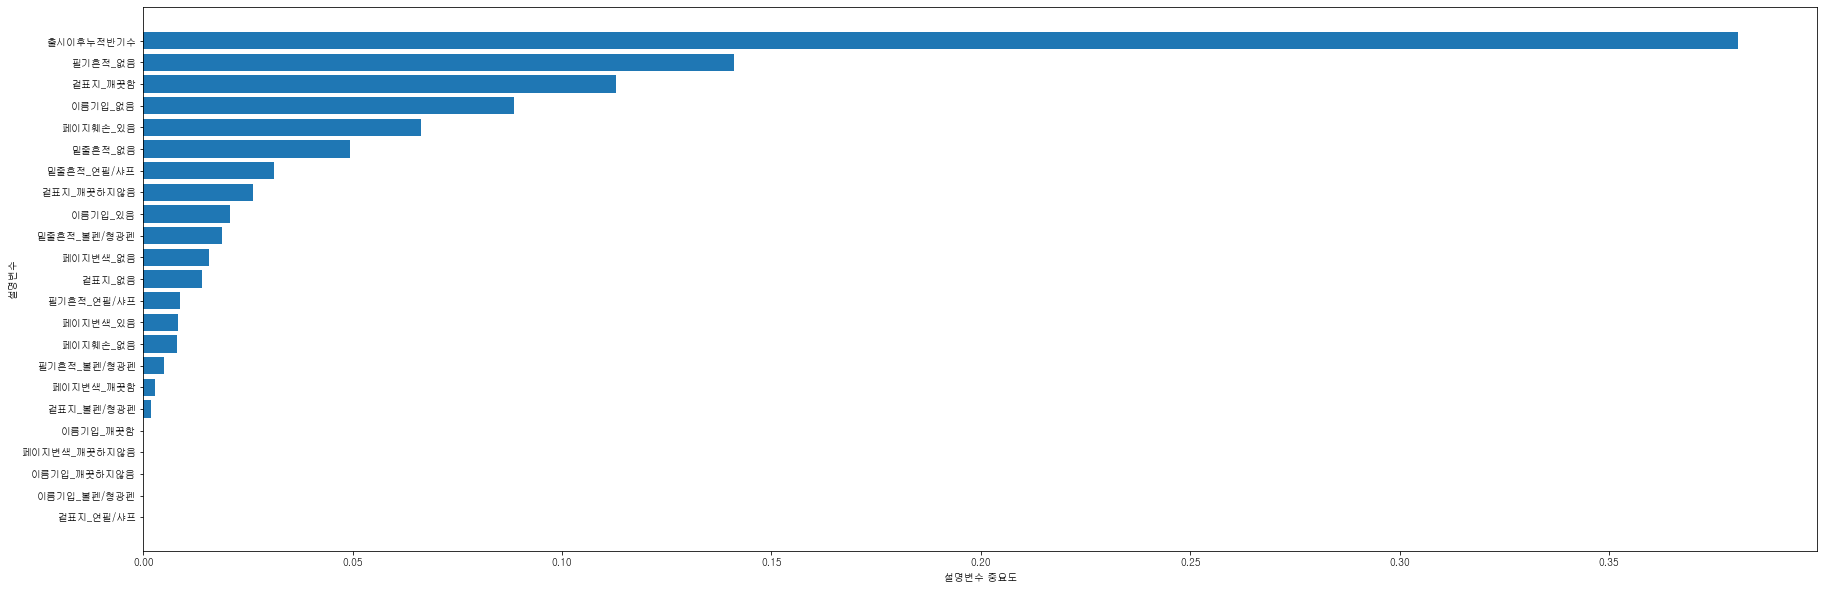

In [104]:
# 변수 중요도를 시각화한 결과는 아래와 같습니다.

df_importance = pd.DataFrame()
df_importance['Feature'] = X_train.columns
df_importance['Importance'] = dtmodel.feature_importances_


df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

In [113]:
!pip install graphviz

In [41]:
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/' # graphviz를 실행하기 위한 환경변수 세팅

# 트리 구조 생성 및 저장
from sklearn.tree import export_graphviz
# 트리 구조 시각화를 위한 라이브러리
import graphviz

In [ ]:
# 의사결정나무를 시각화하는 코드입니다.

export_graphviz(dtmodel, out_file='tree_model.dot', feature_names=X_train.columns, impurity=True, filled=True)

with open("tree_model.dot", encoding='UTF8') as f:
    dot_graph = f.read()
src = graphviz.Source(dot_graph)
src

# 3-2.할인율 구간(밴드) 분류하는 Decision Tree Model 만들기
    할인율에 대해 회귀예측을 하는 것을 진행해봤습니다. 이번에는 좀 더 직관적으로 할인율을 구간을 만든 밴드를 바탕으로 분류를 수행해보도록 하겠습니다.

In [75]:
def discount_band(discount_rate):
    if discount_rate <= 0.2:
        return 0
    elif discount_rate <= 0.4:
        return 1
    elif discount_rate <= 0.6:
        return 2
    elif discount_rate <= 0.8:
        return 3
    else:
        return 4

In [76]:
final_df['할인율_밴드'] = final_df['할인율'].apply(discount_band)

In [77]:
final_df.head()

,출시이후누적반기수,필기흔적_볼펜/형광펜,필기흔적_없음,필기흔적_연필/샤프,밑줄흔적_볼펜/형광펜,밑줄흔적_없음,밑줄흔적_연필/샤프,겉표지_깨끗하지않음,겉표지_깨끗함,겉표지_볼펜/형광펜,...,이름기입_없음,이름기입_있음,페이지변색_깨끗하지않음,페이지변색_깨끗함,페이지변색_없음,페이지변색_있음,페이지훼손_없음,페이지훼손_있음,할인율,할인율_밴드
5,9,0,1,0,0,0,1,0,1,0,...,1,0,0,0,1,0,1,0,0.722222,3
6,9,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,1,0,0.666667,3
7,9,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,1,0,0.722222,3
8,9,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,1,0,0.722222,3
9,9,0,1,0,0,1,0,0,1,0,...,1,0,0,0,1,0,1,0,0.722222,3


In [80]:
from sklearn.tree import DecisionTreeClassifier

X = final_df.drop(columns=['할인율', '할인율_밴드'])
y = final_df['할인율_밴드']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

dt_classifier = DecisionTreeClassifier(max_depth=5, random_state=2022)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=2022)

In [97]:
# 할인율 구간을 설정해 5개 구간에 대한 분류모델을 제작한 결과, 정확도는 0.652로 정확도가 아주 좋지는 않은 모델이 완성되었습니다.
# 추후 EDA를 통해 데이터에 적합한 밴드를 구성해야할 필요성이 있는 대목입니다.

y_pred = dt_classifier.predict(X_test)
print('Accuracy: {0:.3f}'.format(dt_classifier.score(X_test,y_test)))

Accuracy: 0.652


In [ ]:
# 의사결정나무 분류모델을 시각화하기 위한 코드입니다.
export_graphviz(dt_classifier, out_file='tree_classifier.dot', feature_names=X_train.columns, impurity=True, filled=True)

with open("tree_classifier.dot", encoding='UTF8') as f:
    dot_graph = f.read()
src = graphviz.Source(dot_graph)
src